# <center>Federated Learning & Secure Multi-Party Computation</center>


## Assessing FL + SMPC for PrivacyBench with Vision Transformers  

As a pivotal component of the PrivacyBench framework, this implementation evaluates Federated Learning (FL) enhanced with Secure Multi-Party Computation (SMPC) using Vision Transformers (ViT). This quantifies the privacy-utility trade-offs in decentralized AI by integrating FL (data privacy) with SMPC (computation privacy), serving as a key benchmark for:  

- **Model Performance**: Accuracy impact of encrypted gradient aggregation in transformer architectures.  
- **Computational Cost**: Training latency and memory overhead from SMPC-secured self-attention mechanisms.  
- **Energy Efficiency**: kWh/$CO{_2}$ footprint of privacy-preserving distributed transformer training.  

----

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [2]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from transformers import ViTForImageClassification

from logging import ERROR

from flwr.common import Context 
from flwr.client import Client, ClientApp
from flwr.client.mod import secaggplus_mod
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn, build_server_app
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset

from src.tracker import reset_base_memory_csv

---

In [3]:
## Replace with appropritate values

data_name_ = "skin_lesions" #"alzheimer" #
base_type_ = "vit"
num_labels_ = 8 #Alzheimer-4 & skin_lesions-8 classlabels
exp_name_ = "SMPC"
experiment_name_ = ExperimentName.FL_SMPC_VIT

In [4]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name = exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True) 

--- 

In [5]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", 
                                                      num_labels=num_labels_, 
                                                      ignore_mismatched_sizes=True
                                                      )

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name= data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn, mods=[secaggplus_mod])

In [6]:
server = build_server_app(
    evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),
    metrics_fn=weighted_average,
    fed_config= fed_config,
    base_type=base_type_,
    num_labels= num_labels_
)


----- 

Set up our backend configurations before running the simulation

> - `init_args`: filter logging coming from the Simulation Engine so it's more readable in notebooks
> - `client_resources`: by default it's assumed this notebook will be ran with a compute, hence allocate to each client 2x CPU and 1 x GPUs.

In [7]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 2, "num_gpus": 1}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-15 04:17:54,393	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-15 04:17:55,363	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-15 04:17:56,043	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_b1063e376806f040.zip' (25.79MiB) to Ray cluster...
2025-05-15 04:17:56,121	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_b1063e376806f040.zip'.
05/15/2025 04:17:57:DEBUG:Asyncio event loop already running.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 04:18:01] 

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 8 minutes 59 seconds


(ClientAppActor pid=19792) 05/15/2025 04:28:01:DEBUG:Node 7253359150554047717: starting stage 2...
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()


(ClientAppActor pid=19793) 


(ClientAppActor pid=19792) 05/15/2025 04:28:06:DEBUG:Node 7253359150554047717: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19793) 05/15/2025 04:28:04:DEBUG:Node 11730319794011054585: starting stage 2...
(ClientAppActor pid=19792) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19792) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=19792) Seed set to 42
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT) [repeated 2x across cluster]
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 7 seconds [repeated 2x across cluster]


(ClientAppActor pid=19792) 05/15/2025 04:37:17:DEBUG:Node 11704132015188090490: starting stage 2...
(ClientAppActor pid=19792) 05/15/2025 04:37:22:DEBUG:Node 11704132015188090490: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=19793) 05/15/2025 04:37:26:DEBUG:Node 11730319794011054585: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 04:37:26:DEBUG:Node 11730319794011054585: stage 3 completes. uploading key shares...
(ClientAppActor pid=19793) 05/15/2025 04:37:26:DEBUG:Node 11704132015188090490: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 04:37:26:DEBUG:Node 11704132015188090490: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation completed.
Some weights of ViTForIma

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 5 seconds


(ClientAppActor pid=19792) 05/15/2025 04:47:49:DEBUG:Node 7253359150554047717: starting stage 2...
(ClientAppActor pid=19793) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19793) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19793)   self.pid = os.fork()


(ClientAppActor pid=19793) 
(ClientAppActor pid=19793) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19793) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19793) ⏱️ Total training time: 9 minutes 7 seconds


(ClientAppActor pid=19792) 05/15/2025 04:47:54:DEBUG:Node 7253359150554047717: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19793) 05/15/2025 04:47:51:DEBUG:Node 11730319794011054585: starting stage 2...
(ClientAppActor pid=19792) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19792) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=19792) Seed set to 42
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 20 seconds


(ClientAppActor pid=19792) 05/15/2025 04:57:19:DEBUG:Node 11704132015188090490: starting stage 2...
(ClientAppActor pid=19792) 05/15/2025 04:57:24:DEBUG:Node 11704132015188090490: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=19793) 05/15/2025 04:57:27:DEBUG:Node 11730319794011054585: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 04:57:27:DEBUG:Node 11730319794011054585: stage 3 completes. uploading key shares...
(ClientAppActor pid=19793) 05/15/2025 04:57:27:DEBUG:Node 11704132015188090490: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 04:57:27:DEBUG:Node 11704132015188090490: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation completed.
Some weights of ViTForIma

(ClientAppActor pid=19793) 
(ClientAppActor pid=19793) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19793) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19793) ⏱️ Total training time: 9 minutes 6 seconds


(ClientAppActor pid=19793) 05/15/2025 05:07:54:DEBUG:Node 11730319794011054585: starting stage 2...
(ClientAppActor pid=19793) 05/15/2025 05:07:59:DEBUG:Node 11730319794011054585: stage 2 completed, uploading masked parameters...


(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 14 seconds


(ClientAppActor pid=19793) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19793) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=19792) 05/15/2025 05:08:01:DEBUG:Node 7253359150554047717: starting stage 2...
(ClientAppActor pid=19793) Seed set to 42
(ClientAppActor pid=19793) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19793) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19793)   self.pid = os.fork()
(ClientAppActor pid=19792) 05/15/2025 05:08:07:DEBUG:Node 7253359150554047717: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19793) /home/emeka/.local/share/uv/python/c

(ClientAppActor pid=19793) 
(ClientAppActor pid=19793) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19793) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19793) ⏱️ Total training time: 9 minutes 16 seconds


(ClientAppActor pid=19793) 05/15/2025 05:17:19:DEBUG:Node 11704132015188090490: starting stage 2...
(ClientAppActor pid=19793) 05/15/2025 05:17:24:DEBUG:Node 11704132015188090490: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=19793) 05/15/2025 05:17:27:DEBUG:Node 7253359150554047717: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 05:17:27:DEBUG:Node 7253359150554047717: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation completed.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream ta

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 8 minutes 59 seconds


(ClientAppActor pid=19792) 05/15/2025 05:27:39:DEBUG:Node 7253359150554047717: starting stage 2...
(ClientAppActor pid=19792) 05/15/2025 05:27:44:DEBUG:Node 7253359150554047717: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19792) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19792) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=19792) Seed set to 42
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()


(ClientAppActor pid=19793) 
(ClientAppActor pid=19793) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19793) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19793) ⏱️ Total training time: 9 minutes 11 seconds


(ClientAppActor pid=19793) 05/15/2025 05:27:51:DEBUG:Node 11730319794011054585: starting stage 2...
(ClientAppActor pid=19793) 05/15/2025 05:27:56:DEBUG:Node 11730319794011054585: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: Deprecatio

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 5 seconds


(ClientAppActor pid=19792) 05/15/2025 05:36:53:DEBUG:Node 11704132015188090490: starting stage 2...
(ClientAppActor pid=19792) 05/15/2025 05:36:58:DEBUG:Node 11704132015188090490: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
DEBUG :     [Stage 3] Received key shares from 3 clients.
(ClientAppActor pid=19793) 05/15/2025 05:37:01:DEBUG:Node 11730319794011054585: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 05:37:01:DEBUG:Node 11730319794011054585: stage 3 completes. uploading key shares...
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation completed.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream 

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT)
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 3 seconds


(ClientAppActor pid=19792) 05/15/2025 05:47:20:DEBUG:Node 7253359150554047717: starting stage 2...
(ClientAppActor pid=19793) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19793) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19793)   self.pid = os.fork()


(ClientAppActor pid=19793) 


(ClientAppActor pid=19792) 05/15/2025 05:47:26:DEBUG:Node 7253359150554047717: stage 2 completed, uploading masked parameters...
(ClientAppActor pid=19793) 05/15/2025 05:47:24:DEBUG:Node 11730319794011054585: starting stage 2...
(ClientAppActor pid=19792) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19792) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(ClientAppActor pid=19792) Seed set to 42
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=19792) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=19792)   self.pid = os.fork()
(ClientAppActor pid=19792) /home/emeka/.local/share/uv/python/

(ClientAppActor pid=19792) 
(ClientAppActor pid=19792) 🔎 Tracker: FL + SMPC (ViT) [repeated 2x across cluster]
(ClientAppActor pid=19792) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/skin_lesions/FL_SMPC_ViT/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=19792) ⏱️ Total training time: 9 minutes 18 seconds [repeated 2x across cluster]


(ClientAppActor pid=19792) 05/15/2025 05:56:47:DEBUG:Node 11704132015188090490: starting stage 2...
(ClientAppActor pid=19792) 05/15/2025 05:56:52:DEBUG:Node 11704132015188090490: stage 2 completed, uploading masked parameters...
DEBUG :     [Stage 2] Received masked vectors from 3 clients.
DEBUG :     [Stage 3] Requesting key shares from 3 clients to remove masks.
(ClientAppActor pid=19793) 05/15/2025 05:56:55:DEBUG:Node 11730319794011054585: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 05:56:55:DEBUG:Node 11730319794011054585: stage 3 completes. uploading key shares...
(ClientAppActor pid=19793) 05/15/2025 05:56:55:DEBUG:Node 11704132015188090490: starting stage 3...
(ClientAppActor pid=19793) 05/15/2025 05:56:55:DEBUG:Node 11704132015188090490: stage 3 completes. uploading key shares...
DEBUG :     [Stage 3] Received key shares from 3 clients.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      Secure aggregation completed.
Some weights of ViTForIma

/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=17592) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()



 ___________________________________________________________________________________________________
ExperimentName.FL_SMPC_VIT Model Final Evaluation 

Test Accuracy: 86.47% | Precision: 0.86 | Recall: 0.86 | F1-Score: 0.86 | ROC-AUC: 0.98 | MCC: 0.81
 


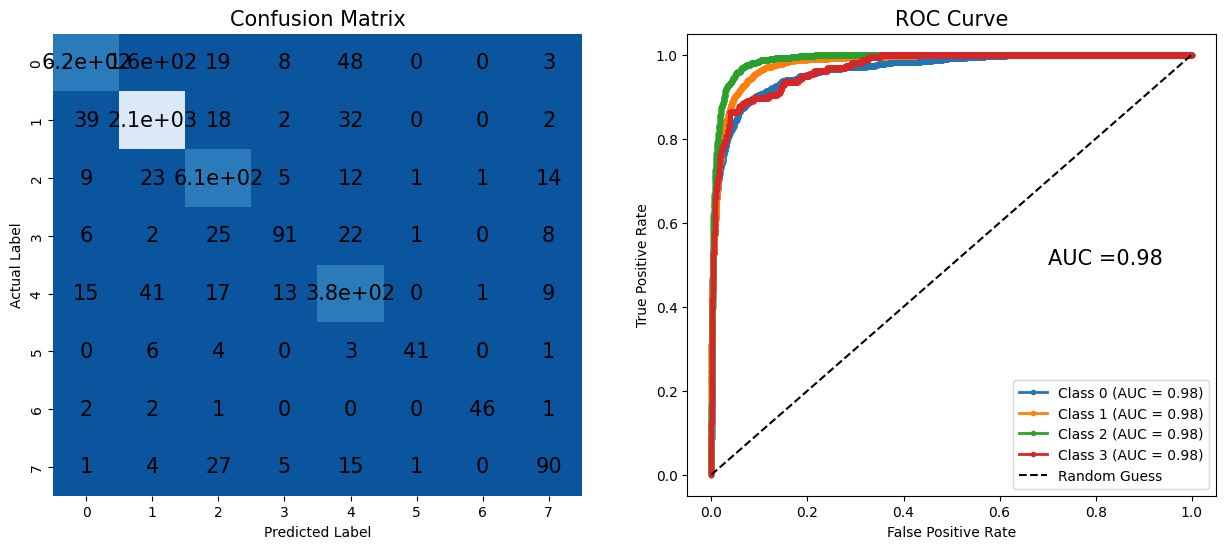


 ___________________________________________________________________________________________________
ExperimentName.FL_SMPC_VIT--skin_lesions Model Classification Report
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       853
           1       0.90      0.96      0.93      2242
           2       0.85      0.90      0.87       674
           3       0.73      0.59      0.65       155
           4       0.74      0.80      0.77       476
           5       0.93      0.75      0.83        55
           6       0.96      0.88      0.92        52
           7       0.70      0.63      0.66       143

    accuracy                           0.86      4650
   macro avg       0.84      0.78      0.80      4650
weighted avg       0.86      0.86      0.86      4650

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 8478.00 sec
✅ Total Energy: 0.3687

Accuracy,▁
F1-Score,▁
MCC,▁
Peak FL CPU RAM (GB),▁
Peak FL GPU VRAM (GB),▁
Precision,▁
ROC-AUC,▁
Recall,▁
Total FL CO2 Emitted (kg),▁
Total FL Duration (sec),▁
Total FL Energy (kWh),▁


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])
INFO :      fit progress: (5, 0.5746630905794095, {'accuracy': 0.8647311827956989}, 6006.326026283)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=19793) Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
(ClientAppActor pid=19793) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(Client


🕒 Total Time: 101 min 18 sec


In [8]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR), 
    runtime_env={
        "env_vars": {"OMP_NUM_THREADS": "1"}, #<--- Prevents thread oversubscription
        "working_dir": project_root,
        'excludes': ['.cache', '.docker', '.local', 'logs/model'],
    },
    ignore_reinit_error=True
    )

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"), #<-- How many clients trains at once  (in parralel)
    backend_config=backend_setup
)

end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()

----